In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
df = pd.read_csv('Purchase_Fraud_Data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,43650,ATGTXKYKUDUQN,SEO,Safari,M,3.840542e+09,0,health_care,3-7-1974
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,45016,NAUITBZFJKHWW,Ads,Safari,M,4.155831e+08,0,home_essentials,25-8-1970


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             146185 non-null  object 
 8   ip_address      151112 non-null  float64
 9   class           151112 non-null  int64  
 10  category        151112 non-null  object 
 11  dob             146188 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 13.8+ MB


In [3]:
df['class'].value_counts(normalize=True)*100

0    90.635423
1     9.364577
Name: class, dtype: float64

In [4]:
df.isna().sum()

user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex               4927
ip_address           0
class                0
category             0
dob               4924
dtype: int64

In [5]:
df.describe()

,user_id,purchase_value,ip_address,class
count,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,50521.469003,2.152145e+09,0.093646
std,115369.285024,28533.667117,1.248497e+09,0.291336
min,2.000000,1016.000000,5.209350e+04,0.000000
25%,100642.500000,25919.000000,1.085934e+09,0.000000
50%,199958.000000,50484.000000,2.154770e+09,0.000000
75%,300054.000000,75296.250000,3.243258e+09,0.000000
max,400000.000000,100092.000000,4.294850e+09,1.000000


In [6]:
df.describe(include=['O'])

,signup_time,purchase_time,device_id,source,browser,sex,category,dob
count,151112,151112,151112,151112,151112,146185,151112,146188
unique,151112,150663,137956,3,5,2,5,13745
top,2015-02-24 22:55:49,2015-09-10 09:04:53,CQTUVBYIWWWBC,SEO,Chrome,M,electronics,24-7-1982
freq,1,3,20,60615,61432,85445,32056,37


In [7]:
len(df)==len(df['user_id'].unique())

True

### <font color='green'>Based on above overview, we can see that there is  missing entries for the features: sex and dob and these are not very insightful later we can remove them, all the user ids are unique in the table. In terms of the percentage of fraudulent activities, current mean rate of fraudulent transactions is 9.36%.</font>

## <font color='blue'>The target variable is class, and there are some features in the table that we can play with for the purpose of feature engineering, this include:</font>
### <font color='green'>Calculate time difference between sign-up time and purchase time;</font>
### <font color='green'>Check whether different users use the same device, which could indicate fake accounts;</font>
### <font color='green'>Check whether different users have the same IP address, which could also be an indicator;</font>
### <font color='green'>Explore other temporal patterns, such as week of the year and day of the week.</font>

In [8]:
df.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976


In [9]:
# Conversion of datatypes for columns: 'signup_time' and 'purchase_time' to datetime64
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['signup_time'] = pd.to_datetime(df['signup_time'])

In [10]:
# Create the time difference column
df['time_diff']=(df['purchase_time']-df['signup_time']).apply(lambda x:x.days)

In [11]:
# Check whether different users use the same device and create a new column to count repeated device use
Temp1=df.groupby('device_id')['user_id'].count().reset_index().rename(columns={'user_id':'device_count'})
df=df.merge(Temp1,how='left',on='device_id')

In [12]:
# Check whether different users use the same IP address and create a new column to count repeated IP use
Temp2=df.groupby('ip_address')['user_id'].count().reset_index().rename(columns={'user_id':'ip_count'})
df=df.merge(Temp2,how='left',on='ip_address')

In [13]:
# Create week of year and day of week columns for sign time and purchase time
df['signup_week']=df['signup_time'].apply(lambda x:x.week)
df['signup_day']=df['signup_time'].apply(lambda x:x.dayofweek)
df['purchase_week']=df['purchase_time'].apply(lambda x:x.week)
df['purchase_day']=df['purchase_time'].apply(lambda x:x.dayofweek)

In [14]:
# Show the new data table
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,time_diff,device_count,ip_count,signup_week,signup_day,purchase_week,purchase_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,52,1,1,9,1,16,5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,0,1,1,23,6,24,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962,0,12,12,1,3,1,3
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,43650,ATGTXKYKUDUQN,SEO,Safari,M,3.840542e+09,0,health_care,3-7-1974,5,1,1,18,1,19,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,45016,NAUITBZFJKHWW,Ads,Safari,M,4.155831e+08,0,home_essentials,25-8-1970,50,1,1,30,1,37,2


### <font color='green'>Now, we may select what features to include in our machine learning model. We will drop user_id, device_id and ip_address as the three columns are just identifiers and don't contain much useful information in themselves. We have also engineered new features from time-related features, therefore, we can also drop signup_time and purchase_time.</font>

In [15]:
columns = ['user_id','signup_time','purchase_time','device_id','ip_address']
df_new=df.drop(columns,axis=1)
df_new.head()

,purchase_value,source,browser,sex,class,category,dob,time_diff,device_count,ip_count,signup_week,signup_day,purchase_week,purchase_day
0,65278,SEO,Chrome,M,0,home_essentials,22-2-1976,52,1,1,9,1,16,5
1,96399,Ads,Chrome,F,0,apparels,2-1-1962,0,1,1,23,6,24,0
2,57296,SEO,Opera,M,1,electronics,5-3-1962,0,12,12,1,3,1,3
3,43650,SEO,Safari,M,0,health_care,3-7-1974,5,1,1,18,1,19,0
4,45016,Ads,Safari,M,0,home_essentials,25-8-1970,50,1,1,30,1,37,2


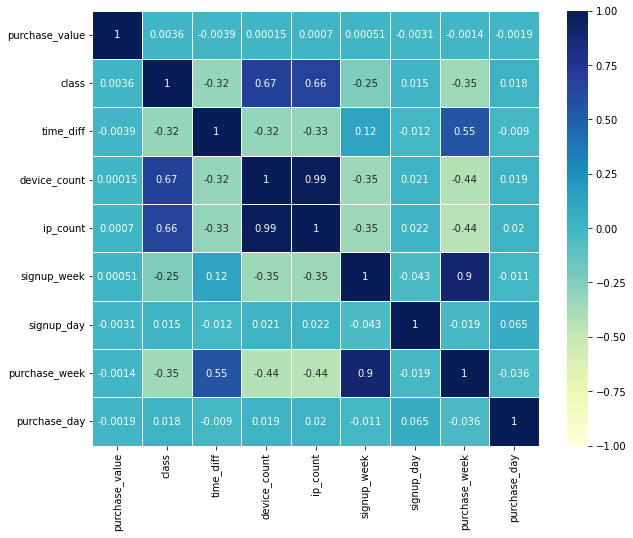

In [16]:
# Pre-check correlation between features and our target variable 'class' using heatmap.
fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df_new.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, cbar=True, linewidths=0.5)
plt.show()

### <font color='blue'>As shown above, device count and ip count have high correlation with the target.</font>

### <font color='green'>Next, we will move on to pick and apply a machine learning model. I will use H2O random forest model here because: random forest requires very little time to optimize (its default parameters are often close to the best ones), and it is strong with both continuous and discrete variables. H2O random forest can handle categorical variables without the need to convert them to numerical ones, which will make things easier for us in this case.</font>

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report

In [18]:
#df_new['source']= df_new['source'].astype("category")

In [19]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   purchase_value  151112 non-null  int64 
 1   source          151112 non-null  object
 2   browser         151112 non-null  object
 3   sex             146185 non-null  object
 4   class           151112 non-null  int64 
 5   category        151112 non-null  object
 6   dob             146188 non-null  object
 7   time_diff       151112 non-null  int64 
 8   device_count    151112 non-null  int64 
 9   ip_count        151112 non-null  int64 
 10  signup_week     151112 non-null  int64 
 11  signup_day      151112 non-null  int64 
 12  purchase_week   151112 non-null  int64 
 13  purchase_day    151112 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 17.3+ MB


In [20]:
# Define features and target
feature = ['purchase_value', 'source', 'browser', 'sex', 'time_diff', 'device_count', 'ip_count',
           'signup_week', 'signup_day', 'purchase_week','purchase_day']
target = 'class'
X=df_new[feature]
y=df_new[target]

In [22]:
# Split the data into 70% training and 30% test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [23]:
X_train.dtypes

purchase_value     int64
source            object
browser           object
sex               object
time_diff          int64
device_count       int64
ip_count           int64
signup_week        int64
signup_day         int64
purchase_week      int64
purchase_day       int64
dtype: object

In [24]:
features_to_encode = list(X_train.select_dtypes(include = ['object']).columns)

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [27]:
#build the classifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=50,
                      max_features='auto')

In [28]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['source', 'browser',
                                                   'sex'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=150,
                                        n_jobs=-1, oob_score=True,
                                        random_state=50))])

In [34]:
from sklearn.metrics import roc_curve, auc, classification_report,accuracy_score
#test the classifier
y_pred = pipe.predict(X_test)

#calculate accuracy
accuracy_score(y_test, y_pred)
#accuracy_score(y_train, pipe.predict(X_train))

0.962253163216687

In [36]:
# Print out classification report
print(classification_report(y_test, (y_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     34262
           1       0.91      0.66      0.77      3516

    accuracy                           0.96     37778
   macro avg       0.94      0.83      0.87     37778
weighted avg       0.96      0.96      0.96     37778

